# <u>Финальный проект</u> <span style="color: #D3D3D3;">by Ponomarenko</span>

In [2]:
import pandas as pd
import numpy as np
import pandahouse as ph

import pingouin as pg
import scipy.stats as st

import requests
from urllib.parse import urlencode 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Настройка графики

setting = sns.set(
           font_scale=1.4,
           style="white",
           rc={'figure.figsize':(20, 7)}
)

In [4]:
# Список соответствия публичных ключей и исходных датафреймов

pb_keys = {
           'df_groups':      'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
           'df_groups_add':  'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', 
           'df_active_studs':'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 
           'df_checks':      'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
          }

In [5]:
# Функция считывания csv-файла по API Яндекс.Диска

def read_yadisk_csv(public_key, delimeter):
    
    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response  = requests.get(final_url) 
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, sep=delimeter)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# <u> Задание 1. A/B - тестирование системы оплаты на сайте<u> 
    
## Методика тестирования и задача:
В ходе A/B–тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В группе A (контрольной) оказались пользователи c базовой механикой оплаты услуг, а в группе B (тестовой) пользователи с новой механикой оплаты услуг на сайте.

**Сделать аналитическое заключение с ответом на вопрос, стоит ли запускать новую механику оплаты на всех пользователей.**

## 1.1 EDA-анализ

Получение основной информации о датафреймах и изучение особенностей данных в них.
### а) Пользователи в группах (df_groups) 

In [6]:
df_groups = read_yadisk_csv(pb_keys['df_groups'], delimeter=';')
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
# Размер df

df_groups.shape

(74484, 2)

In [8]:
# Пропущенные значения не обнаружены

df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
# Список пользоватателей полностью уникален

df_groups.nunique()

id     74484
grp        2
dtype: int64

In [10]:
# Количество пользователей в группах

df_groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [11]:
# Типы данных 

df_groups.dtypes

id      int64
grp    object
dtype: object

### б) Пользователи в группах - дополнительные (df_groups_add)

In [7]:
df_groups_add = read_yadisk_csv(pb_keys['df_groups_add'], delimeter=',')
df_groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [13]:
# Размер df

df_groups_add.shape

(92, 2)

In [14]:
# Пропущенные значения не обнаружены

df_groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
# Список пользоватателей полностью уникален

df_groups_add.nunique()

id     92
grp     2
dtype: int64

In [16]:
# Количество пользователей в группах

df_groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [17]:
# Типы данных

df_groups.dtypes

id      int64
grp    object
dtype: object

### в) Пользователи - участники тестирования (df_active_studs)

In [8]:
df_active_studs = read_yadisk_csv(pb_keys['df_active_studs'], delimeter=';')
df_active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [19]:
# Размер df

df_active_studs.shape

(8341, 1)

In [20]:
# Пропущенные значения не обнаружены

df_active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
# Список пользоватателей полностью уникален

df_active_studs.nunique()

student_id    8341
dtype: int64

In [22]:
# Типы данных 

df_active_studs.dtypes

student_id    int64
dtype: object

### г) Расходы пользователей - участников тестирования (df_checks)

In [9]:
df_checks = read_yadisk_csv(pb_keys['df_checks'], delimeter=';')
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
# Размер df

df_checks.shape

(541, 2)

In [25]:
# Пропущенные значения не обнаружены

df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [26]:
# Список пользоватателей полностью уникален

df_checks.nunique()

student_id    541
rev            39
dtype: int64

In [27]:
# Типы данных 

df_checks.dtypes

student_id      int64
rev           float64
dtype: object

## 1.2 Предподготовка данных для анализа

В данном разделе проверяются возможные аномалии и отбираются необходимые данные для анализа результатов A/B - тестирования

In [26]:
# Информация о принадлежности всех пользователей к группам

df_all_groups = pd.concat([df_groups, df_groups_add], ignore_index=True)
df_all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


**Проверим уникальность пользователей df_groups и df_groups_add относительно друг друга**

In [71]:
result_check = df_all_groups.id.nunique() == df_groups.shape[0] + df_groups_add.shape[0]

print(f'Списки пользователей уникальны относительно друг друга = {result_check}')

Списки пользователей уникальны относительно друг друга = True


**Проверим есть ли пользователи участники эксперимента, которых нет в общем списке df_all_groups**

In [81]:
result_check = df_active_studs.merge(df_all_groups, left_on='student_id', right_on='id', how='left').id.isna().sum() == 0

print(f'Все пользователи, принимавшие участие в эксперименте, есть в общем списке df_all_groups = {result_check}')

Все пользователи, принимавшие участие в эксперименте, есть в общем списке df_all_groups = True


**Проверим есть ли пользователи совершившие оплату, но не являющиееся участниками эксперимента**

In [54]:
# Пользователи не участвующие в эксперименте

not_active_users = df_all_groups[~df_all_groups.id.isin(df_active_studs.student_id)]
not_active_users.shape[0]

66235

In [87]:
by_grp = not_active_users[not_active_users.id.isin(df_checks.student_id)].grp.value_counts()
by_grp

B    120
A     29
Name: grp, dtype: int64

In [100]:
result_check = not_active_users[not_active_users.id.isin(df_checks.student_id)].shape[0]

print(f'Пользователей совершивших оплату, но не являющихся участниками эксперимента = {result_check} человек')
print(f"\nВ группе A (контрольной): {by_grp['A']} человек")
print(f"В группе B (тестовой):    {by_grp['B']} человек")

Пользователей совершивших оплату, но не являющихся участниками эксперимента = 149 человек

В группе A (контрольной): 29 человек
В группе B (тестовой):    120 человек


**Примечание:** 
- Списки пользователей `df_groups` и `df_groups_add` уникальны относительно друг друга (аномалий нет);
- Все пользователи `df_active_studs`, принимавшие участие в эксперименте, есть в общем списке `df_all_groups` (аномалий нет);
- Обнаружено 149 пользователей, которые отнесены к группам и совершали оплату в срок проведения эксперимента, но отсутствуют в списке участников эксперимента `df_active_studs`. Информацию по этим пользователям надо уточнять, тут возможны различные сценарии: от ошибки в дизайне АБ-теста до возможности оплаты без использования исследуемого функционала. На данный момент этих пользователей в анализе учитывать не будем.

**Сформируем датафрейм с необходимыми данными для анализа**

In [15]:
# Полная информация о всех участниках эксперимента 

df_all_groups = df_all_groups.merge(df_active_studs, left_on='id', right_on='student_id')
df_all_groups.head()

,id,grp,student_id
0,1627,A,1627
1,2085,B,2085
2,2215,B,2215
3,3391,A,3391
4,3401,B,3401


In [16]:
# Полная информация о всех участниках эксперимента с размером их расходов

df_info = df_all_groups.merge(df_checks, on='student_id', how='left').drop('student_id', axis=1)
df_info.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN


In [17]:
# Количество пользователей в группах

df_info.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [18]:
# Введем категориальную переменную

# 0 - пользовататель не совершил оплату услуг на сайте в период эксперимента
# 1 - пользователь совершил оплату услуг на сайте

df_info['payment'] = np.where(df_info.rev.isna(), 0, 1)
df_info.head()

,id,grp,rev,payment
0,1627,A,990.0,1
1,2085,B,NaN,0
2,2215,B,NaN,0
3,3391,A,NaN,0
4,3401,B,NaN,0


# <u> Анализ результатов A/B - тестирования<u> 

### 1. Конверсия посещений сайта в оплату услуги

Предположим, что новая механика на сайте значительно повышает удобство и скорость процедуры оплаты и теперь больше пользователей совершают целевое действие в виде оплаты услуги. У нас имеются две категориальные переменные, тогда для проверки этой гипотезы → **воспользуемся критерием хи-квадрат**

- $H_0$: конверсия в оплату в группах равна
- $H_1$: конверсия в оплату в группах различается

In [102]:
# Создадим таблицу сопряженности 

pd.crosstab(df_info.grp, df_info.payment)

payment,0,1
grp,,
A,1460,78
B,6489,314


In [103]:
# Хи-квадрат тест независимости переменных в таблице сопряженности (без поправки Йетса)

stat, p, dof, expected  = st.chi2_contingency(pd.crosstab(df_info.grp, df_info.payment), correction=False)

**Примечание:** поправка Йетса используется для сравнения небольших выборок с ожидаемой частотой ниже 5.

In [104]:
# Статистика и p-value (> 0.05)

print('Статистика:\t', round(stat, 3))
print('p-value:\t', round(p, 3))

Статистика:	 0.582
p-value:	 0.445


In [105]:
# Конверсия в оплату по группам

CR_groups = pd.crosstab(df_info.grp, df_info.payment, normalize='index') \
                        .rename(columns={1:'CR'}) \
                        .mul(100)[['CR']] \
                        .reset_index()

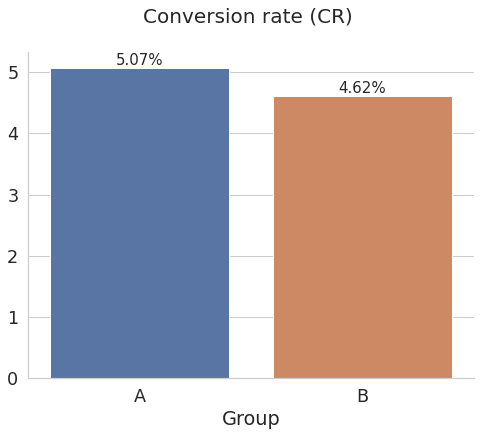

In [106]:
# Визуализация конверсии

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6, style="whitegrid")
ax = sns.barplot(data=CR_groups, x='grp', y='CR')
ax.set(xlabel='Group', ylabel='')
ax.set_title('Conversion rate (CR) ', pad=30, fontsize=20)

for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=15)
sns.despine()
plt.show()

### Вывод №1:

Результаты теста не позволяют нам отклонить нулевую гипотезу (H0), следовательно, мы не можем утверждать, что новая механика оплаты услуг на сайте приводит к изменению конверсии в оплату среди посетителей.

### 2. Средний доход с платящего пользователя

Проверим, повлияло ли изменение механики оплаты на доход бизнеса с платящих пользователей. Будем предполагать, что новая механика может мотивировать некоторых пользователей оплачивать больше услуг с помощью данного сайта, а следовательно увеличится и  доход бизнеса.

In [54]:
# Оставим только платящих пользователей

df_info = df_info.query('payment == 1')

In [55]:
# Количество платящих пользователей в группах

df_info.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

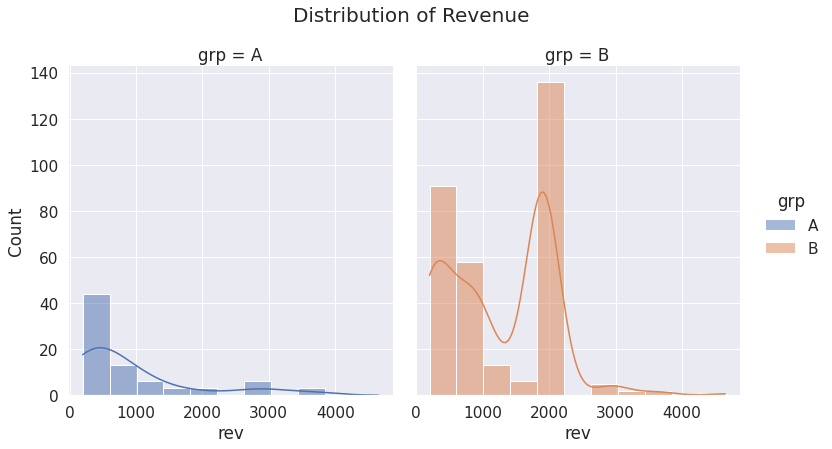

In [57]:
# Построим распредление дохода с пользователей

sns.set(font_scale=1.4, style="darkgrid")
ax = sns.displot(df_info.fillna(0), height=6, aspect=0.9, x='rev', hue='grp', col='grp', kde=True)
ax.fig.suptitle('Distribution of Revenue', fontsize=20, y=1.05)
plt.show()

**Проверим распределения на гомогенность дисперсий и нормальность**

In [58]:
# Проверка гомогенности дисперсий по критерию Левена

stat, p_val = st.levene(df_info.query("grp == 'A'").rev, \
                        df_info.query("grp == 'B'").rev)
print(f'В рассмотренных распределениях дисперсии гомогенны = {p_val > 0.05}')

В рассмотренных распределениях дисперсии гомогенны = True


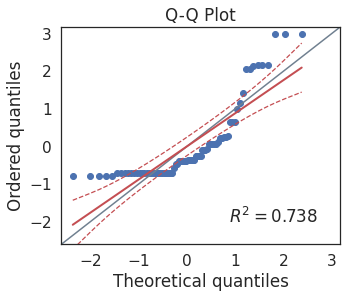

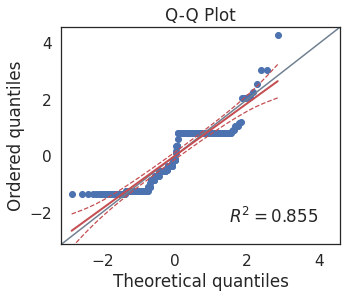

In [34]:
# Проверка нормальности c помощью qqplot 

pg.qqplot(df_info.query("grp == 'A'").rev)
pg.qqplot(df_info.query("grp == 'B'").rev)
plt.show()

**Примечание:** графики Q-Qplot имеют большие хвосты слева и справа, изломы и разряженные значения, следовательно, данные распределения с большой вероятностью не подчиняются нормальному закону.

In [33]:
# Проверка нормальности распределения (тест Д'Агостино-Пирсона)

stat_A, p_val_A = st.normaltest(df_info.query("grp == 'A'").rev)
stat_B, p_val_B = st.normaltest(df_info.query("grp == 'B'").rev)

print(f'Группа А (control): pvalue = {round(p_val_A, 10)}')
print(f'Группа B (test):    pvalue = {round(p_val_B, 5)}')

print(f'\nГруппа А (control): Распределение нормальное = {p_val_A > 0.05}')
print(f'Группа B (test):    Распределение нормальное = {p_val_B > 0.05}')

Группа А (control): pvalue = 2.532e-07
Группа B (test):    pvalue = 0.03345

Группа А (control): Распределение нормальное = False
Группа B (test):    Распределение нормальное = False


**Формулировка гипотез и выбор теста**

Для исследуемой метрики параметрические предположения не выполняются: дисперсии гомогенны, но распределения не подчиняются нормальному закону, более того распределения ассиметричны и имеют выбросы. Стандартный T-test Стьюдента в таких случаях может быть не лучшим решением так как повышается возможная вероятность ошибки I рода, а непараметрические критерии, например Манна-Уитни, сложно интерпретируются и не применимы для сравнения средних в группах, по этой причине для сравнения средних значений дохода с платящего пользователя (ARPPU) будем применять другой статистический тест → **Bootstrap**.

- $H_0$: в группах средний доход с платящего пользователя (ARPPU) равен
- $H_1$: в группах средний доход с платящего пользователя (ARPPU) различается

In [59]:
# Разбиваем доход пользователей по группам

control_group = df_info.query("grp == 'A'").rev
test_group = df_info.query("grp == 'B'").rev 

In [60]:
# Моделирование бутстрапа

diff_ARPPU = []

for i in range(10000):
    sample_data_control = control_group.sample(frac=1, replace=True)
    sample_ARPPU_control = sample_data_control.mean()
    
    sample_data_test = test_group.sample(frac=1, replace=True)
    sample_ARPPU_test = sample_data_test.mean()
    
    sample_ARPPU_diff = sample_ARPPU_test - sample_ARPPU_control
    diff_ARPPU.append(sample_ARPPU_diff)

In [61]:
# Верхняя граница 95% доверительного интервала

upper_bound = pd.Series(diff_ARPPU).quantile(0.975)
upper_bound.round(3)

540.181

In [62]:
# Нижняя граница 95% доверительного интервала

lower_bound = pd.Series(diff_ARPPU).quantile(0.025)
lower_bound.round(3)

94.994

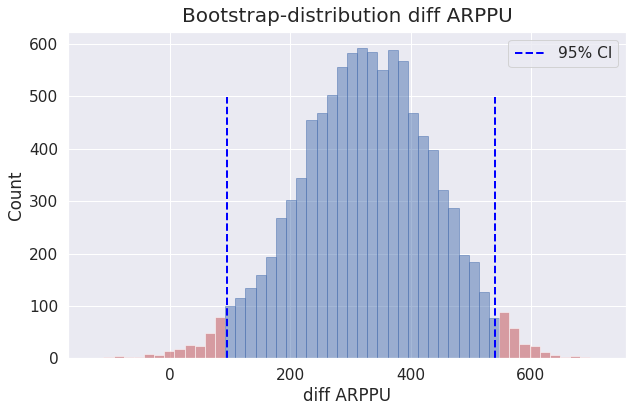

In [118]:
# Визуализация бутстрап-распредления разностей ARPPU

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.4, style="darkgrid")
n, bins, patches = plt.hist(diff_ARPPU, 50, facecolor='r', alpha=0.5)
for i, patch in enumerate(patches):
    if bins[i] >= lower_bound and bins[i+1] <= upper_bound:
        patch.set_color('b')
    elif bins[i] <= lower_bound < bins[i+1]:
        patch.set_color('b')
    elif bins[i] <= upper_bound < bins[i+1]:
        patch.set_color('b')
    
plt.axvline(lower_bound, ymax = 0.8, color='blue', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(upper_bound, ymax = 0.8, color='blue', linestyle='dashed', linewidth=2)
plt.title('Bootstrap-distribution diff ARPPU', pad=10, fontsize=20)
plt.xlabel('diff ARPPU')
plt.ylabel('Count')
plt.legend()
plt.show()

In [105]:
# Средний доход с платящего пользователя по группам

APPU_groups = df_info \
                .groupby('grp', as_index=False) \
                .agg({'rev': 'sum', 'id':'count'}) \
                .rename(columns={'rev':'sum_rev', 'id':'users'})

APPU_groups['ARPPU'] = APPU_groups.sum_rev / APPU_groups.users

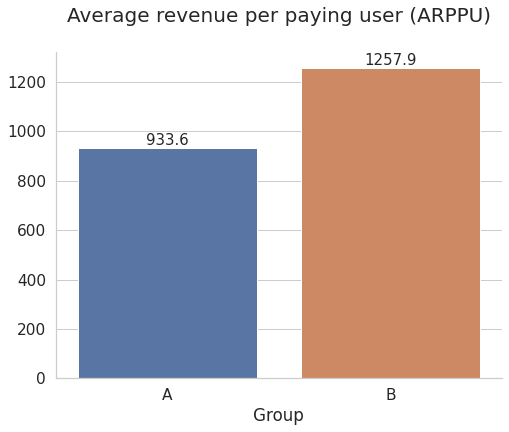

In [113]:
# Визуализация ARPPU

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4, style="whitegrid")
ax = sns.barplot(data=APPU_groups, x='grp', y='ARPPU')
ax.set(xlabel='Group', ylabel='')
ax.set_title('Average revenue per paying user (ARPPU)', pad=30, fontsize=20)

for p in ax.patches:
    percentage = '{:.1f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=15)
sns.despine()
plt.show()

### Вывод №2:

По результатам проведенного Bootstrap'а полученный доверительный интервал разности ARPPU между группами не включает в себя ноль, следовательно, целесообразно отвергнуть нулевую гипотезу и принять альтернативную (H1): **в группах средний доход с платящего пользователя (ARPPU) различается**. <br/> 

Тогда можем заключить, что при внедрении новой механики оплаты услуг пользователи начинают приносить бизнесу статистически значимо больший доход.

## Заключение:

При использовании новой механики оплаты услуг не обнаружено существенное изменение конверсии из посещений сайта в оплату, однако статистически значимо повышается доход бизнеса с платящих пользователей. <br/> 

**Следовательно, новая механика считается эффективной и рекомендуется включать ее для всех пользователей.**

**Примечание:** Нельзя не заметить, что в в тестовой группе возникает большой сегмент пользователей, которые приносят значительный доход бизнесу. Необходимо обратить внимание на этот сегмент пользователей и провести анализ. Возможно новая механика за счет оптимизации и удобства приобрела лояльность какого то конкретного типа пользователей (по статусу, по платежеспособности и т.д.). Данная информация может оказаться полезной для понимания конкурентных преимуществ нашего продукта.

# <u> Задание 2. Python + SQL (ClickHouse)<u> 
    
В данном блоке проводился анализ деятельности образовательного проекта с использованием Python и SQL
    
## 2.1 EDA-анализ

Получение основной информации о таблицах БД и изучение особенностей данных в них.

In [61]:
# Подключение к ClickHouse

connection_default = {
                      'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                      }

### а) Данные о выполнении заданий на курсах (df_peas)

In [62]:
sql_request = '''
            SELECT
                st_id,
                correct,
                timest::varchar as timest,
                subject
            FROM peas;
            
              '''
df_peas = ph.read_clickhouse(sql_request, connection=connection_default)
df_peas.head()

,st_id,correct,timest,subject
0,100379,1,2021-10-30 13:32:29.000,Theory of probability
1,100379,0,2021-10-30 14:11:19.000,Vizualization
2,100379,1,2021-10-30 15:54:22.000,Theory of probability
3,100379,1,2021-10-30 16:44:50.000,Vizualization
4,100379,1,2021-10-30 17:15:05.000,Theory of probability


In [63]:
# Размер df

df_peas.shape

(13245, 4)

In [64]:
# Уникальные значения

df_peas.nunique()

st_id        308
correct        2
timest     12238
subject        5
dtype: int64

**Примечание:** заметим, что время выполнения заданий (`timest`) не уникально, следовательно, возможно совпадение времени выполнения между студентами, а также аномалии одновременного выполнения нескольких заданий одним студентом.

In [65]:
# Пример аномалий в данных (встречаются полные дубликаты)

df_peas[df_peas.duplicated()]

,st_id,correct,timest,subject
1024,219238,0,2021-10-31 06:06:03.000,Python
1986,290349,1,2021-10-31 10:04:36.000,Theory of probability
5108,489093,0,2021-10-31 16:30:39.000,Math
6254,577659,0,2021-10-31 16:43:35.000,Vizualization
7468,658294,1,2021-10-30 15:55:05.000,Python
11519,899745,0,2021-10-31 17:22:15.000,Math
12721,976310,1,2021-10-31 17:10:39.000,Statistics


In [66]:
# Пропущенных значений не обнаружено

df_peas.isna().sum()

st_id      0
correct    0
timest     0
subject    0
dtype: int64

### б) Распредение студентов по группам (df_studs)

In [67]:
sql_request = '''
            SELECT *
            FROM studs;
            
              '''
df_studs = ph.read_clickhouse(sql_request, connection=connection_default)
df_studs.head()

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [68]:
# Размер df

df_studs.shape

(600, 2)

In [69]:
# Значения в таблице полностью уникальны

df_studs.nunique()

st_id       600
test_grp      2
dtype: int64

In [70]:
# Пропущенных значений не обнаружено

df_studs.isna().sum()

st_id       0
test_grp    0
dtype: int64

### в) Данные о покупках платных подписок на курсы (df_checks)

In [71]:
sql_request = '''
            SELECT
                st_id,
                sale_time::varchar as sale_time,
                money,
                subject
            FROM final_project_check;
            
              '''
df_checks = ph.read_clickhouse(sql_request, connection=connection_default)
df_checks.head()

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32.000,85000,Math
1,101432,2021-10-31 12:43:50.000,65000,Vizualization
2,104885,2021-10-30 17:05:55.000,65000,Vizualization
3,104885,2021-10-30 22:49:33.000,75000,Statistics
4,106464,2021-10-31 13:17:13.000,85000,Math


In [72]:
# Размер df

df_checks.shape

(61, 4)

In [73]:
# Уникальные значения

df_checks.nunique()

st_id        47
sale_time    61
money         5
subject       5
dtype: int64

In [74]:
# Пропущенных значений не обнаружено

df_checks.isna().sum()

st_id        0
sale_time    0
money        0
subject      0
dtype: int64

## 2.2 Очень усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 заданий. <br/>

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [75]:
# Оптимальный вариант запроса

sql_request = '''
            WITH (
                SELECT
                    MAX(toStartOfMonth(timest))
                FROM peas
            ) as current_month

            SELECT 
                COUNT(*) diligent_students
            FROM (
                SELECT
                    st_id,
                    uniqExact(timest)
                FROM peas
                WHERE correct = 1
                    AND toStartOfMonth(timest) = current_month
                GROUP BY st_id
                HAVING uniqExact(timest) >= 20
            ) as tb; 
            
              '''
students = ph.read_clickhouse(sql_request, connection=connection_default)
print(f'В текущем месяце {students.diligent_students[0]} усердных студентов')

В текущем месяце 136 усердных студентов


**Примечание**: 
- Common Table Expressions (CTE) используется, чтобы всегда выбирать последний месяц в данных (current_month) при использовании запроса (в нашем случае его можно было не использовать так как в данных только один месяц).
- uniqExact применяется, чтобы избежать подсчета возможных дубликатов (очевидно, что время выполнения "горошин" не может быть одинаковым с точностью до секунд у одного и того же студента, однако в данных такое встречается).

## 2.3 Оптимизация воронки

Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.<br/>
**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.<br/>
**Активным по математике** считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [77]:
sql_request = '''
    WITH active_users as (
        SELECT st_id
        FROM peas
        WHERE correct = 1
        GROUP BY st_id
        HAVING COUNT(DISTINCT timest) > 10
    ),
    active_math_users as (
        SELECT st_id
        FROM peas
        WHERE correct = 1
            AND subject = 'Math'
        GROUP BY st_id
        HAVING COUNT(DISTINCT timest) >= 2
    ),
    metric_info as (
        SELECT 
            test_grp,
            COALESCE(SUM(money), 0)                                                                   as Revenue,
            COUNT(DISTINCT st_id)                                                                     as All_users,
            COUNT(DISTINCT st_id) FILTER (WHERE st_id IN (SELECT * FROM active_users))                as Active_users,
            COUNT(DISTINCT st_id) FILTER (WHERE money <> 0)                                           as Customers,
            COUNT(DISTINCT st_id) FILTER (WHERE money <> 0 AND st_id IN (SELECT * FROM active_users)) as Active_customers,
            COUNT(DISTINCT st_id) FILTER (WHERE st_id IN (SELECT * FROM active_math_users))           as Active_users_math,
            COUNT(DISTINCT st_id) FILTER (WHERE subject = 'Math' 
                                            AND st_id IN (SELECT * FROM active_math_users))           as Active_customers_math
        FROM 
            studs
        LEFT JOIN final_project_check
            USING(st_id)
        GROUP BY 
            test_grp
    )

    SELECT
        test_grp as group,
        ROUND(Revenue / All_users, 2) as ARPU,
        ROUND(Revenue / NULLIF(Active_users, 0), 2) as ARPAU,
        ROUND(Customers / All_users, 4) * 100  as CR_purchase,
        ROUND(Active_customers / NULLIF(Active_users, 0), 4) * 100  as CR_purchase_active,
        ROUND(Active_customers_math / NULLIF(Active_users_math, 0), 4) * 100  as CR_purchase_active_math
    FROM metric_info;
    
              '''
metrics = ph.read_clickhouse(sql_request, connection=connection_default)
metrics

,group,ARPU,ARPAU,CR_purchase,CR_purchase_active,CR_purchase_active_math
0,control,4540.98,10905.51,4.92,11.02,6.12
1,pilot,11508.47,35364.58,10.85,26.04,9.52


**Примечание**:
- Первые подзапросы в Common Table Expressions (CTE) используются, чтобы выбрать отдельно активных (active_users) и активных по математике (active_math_users) пользователей. 
- В последствии эти подзапросы используются внутри следующего CTE подзапроса (metric_info) для продвинутой фильтрации с помощью оператора FILTER WHERE. Схожий функционал возможно реализовать и с применением оператора CASE, однако в контексте задачи видится целесообразным применять более компактный метод.
- Необходимость использования COUNT(DISTINCT ..) объясняется тем, что в при использовании LEFT JOIN декартово произведение дублирует st_id для пользователей купивших несколько платных курсов и данная колонка БД теряет свойство уникальности данных, выявленное при EDA-анализе. 
- Применение оператора COALESCE при подсчете маржинальной прибыли образовательного проекта необязательно, однако обеспечивает гибкость и надежность запроса, например, в случаях когда платных покупок курсов не совершено.
- Аналогично предыдущему оператор NULLIF позволяет также обеспечить надежность и гибкость запроса, например, в случаях, когда количество активных пользователей может быть равно нулю.

# <u> Задание 3. Python<u> 
    
Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [108]:
# Продублируем ранее созданные ключи

pb_keys = {
           'df_groups':      'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
           'df_groups_add':  'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', 
           'df_active_studs':'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 
           'df_checks':      'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
          }

In [109]:
def read_yadisk_csv(public_key, delimeter):
    
    # Формирование url    
    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    # Загрузка csv-файла    
    response  = requests.get(final_url) 
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, sep=delimeter)

In [110]:
def recalculate_metrics(pb_keys: dict):
    
    # Загрузка данных
    df_groups = read_yadisk_csv(pb_keys['df_groups'], delimeter=';')

    df_groups_add = read_yadisk_csv(pb_keys['df_groups_add'], delimeter=',')
    df_groups_add.rename(columns={df_groups_add.columns[0]:'id', df_groups_add.columns[1]:'grp'}, inplace=True)

    df_active_studs = read_yadisk_csv(pb_keys['df_active_studs'], delimeter=';')
    df_active_studs.rename(columns={df_active_studs.columns[0]:'id'}, inplace=True)

    df_checks = read_yadisk_csv(pb_keys['df_checks'], delimeter=';')
    df_checks.rename(columns={df_checks.columns[0]:'id'}, inplace=True)
    
    # Объединение данных
    df_info = df_groups.merge(df_groups_add, how='outer', on=['id', 'grp']) \
                       .merge(df_active_studs, on='id') \
                       .merge(df_checks, how='left', on='id')
    
    # Пересчет метрик
    metrics = pd.DataFrame(index=['A', 'B'])
    metrics[ 'CR'  ] = df_info.groupby('grp').apply(lambda x: x.rev.count() / x.shape[0]).mul(100)
    metrics['ARPPU'] = df_info.groupby('grp').apply(lambda x: x.rev.sum()  / x.rev.count())
    metrics['ARPAU'] = df_info.groupby('grp').apply(lambda x: x.rev.sum() / x.shape[0])
    
    return metrics

Теперь реализуем функцию, которая будет строить графики по получаемым метрикам.

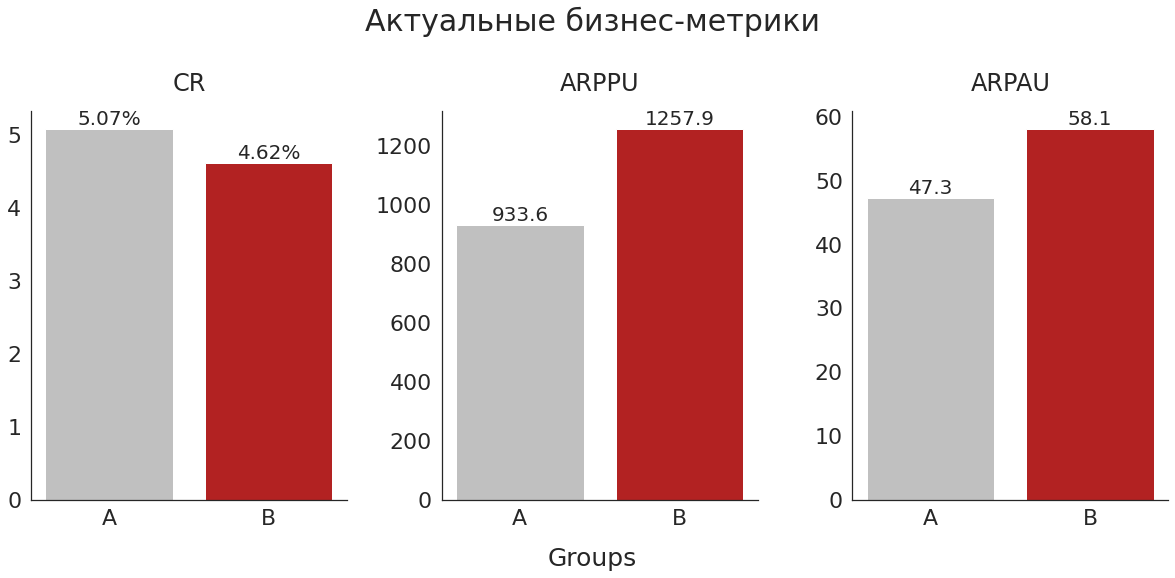

In [112]:
def metrics_visualization(pb_keys: dict):
    
    # Предобработка входных данных
    current_metrics = recalculate_metrics(pb_keys)
    current_metrics.index.name = 'grp'
    current_metrics.reset_index(inplace=True)
    
    # Стиль заднего фона
    sns.set(font_scale=2, style="white")
    
    # Добавление осей графикам
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    
    # Названия метрик 
    metric_labels = ['CR', 'ARPPU', 'ARPAU']
    
    # Построение графиков с подписанными значениями
    for ax, label in zip(axs, metric_labels):
        ax.bar(current_metrics['grp'], current_metrics[label], color=['silver', 'firebrick'])
        ax.set(xlabel='', ylabel='')
        ax.set_title(label, pad=20)
        for p in ax.patches:
            if label == 'CR':
                format_val = '{:.2f}%'.format(p.get_height())
            else:
                format_val = '{:.1f}'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(format_val, (x, y), ha='center', va='bottom', fontsize=20)
    
    # Создание заголовков и подписей   
    fig.suptitle('Актуальные бизнес-метрики', fontsize=30)
    fig.text(0.5, 0.01, 'Groups', ha='center', fontsize=25)
    
    # Настройка отображения
    plt.subplots_adjust(wspace=0.3, left=0.11, top=0.8)
    sns.despine()
    plt.show()

metrics_visualization(pb_keys)